In [1]:
import sys
from pathlib import Path
import os
absolute_path = os.fspath(Path.cwd().parent)
if absolute_path not in sys.path:
    sys.path.append(absolute_path)

import random
import math
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
sns.set_theme()

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering


from src.main.plot.figures import *

In [2]:
tx_chain = 'eth_std' 
p = 1 # ratio of data

In [3]:
relative_path_to_data = '/data/features/' + tx_chain 
path_to_data = absolute_path + relative_path_to_data
files = os.listdir(path_to_data)

In [4]:
df_eth = pd.read_csv(os.path.join(path_to_data, files[0]), index_col=0, skiprows=lambda i: i>0 and random.random() > p)
print(df_eth.shape)
df_eth.head(2)

(19027, 164)


,countUniqueInteracted,ratioUniqueInteracted,countTx,outgoing,outgoingRatio,gas__approximate_entropy__m_2__r_0.1,gas__approximate_entropy__m_2__r_0.3,gas__approximate_entropy__m_2__r_0.5,gas__approximate_entropy__m_2__r_0.7,gas__approximate_entropy__m_2__r_0.9,...,value__variation_coefficient,value__percentage_of_reoccurring_datapoints_to_all_datapoints,value__percentage_of_reoccurring_values_to_all_values,value__permutation_entropy__dimension_3__tau_1,value__permutation_entropy__dimension_4__tau_1,value__permutation_entropy__dimension_5__tau_1,value__ratio_beyond_r_sigma__r_1,value__ratio_beyond_r_sigma__r_2,value__ratio_beyond_r_sigma__r_6,value__ratio_value_number_to_time_series_length
address,,,,,,,,,,,,,,,,,,,,,
0x00000000000cd56832ce5dfbcbff02e7ec639bc9,328.0,0.307981,1065,1047,0.983099,1.147788,0.69575,0.442939,0.293566,0.243445,...,9.990080,0.8723,0.326733,1.410346,2.371219,3.365849,0.00939,0.003756,0.001878,0.189671
0x000000000f709dfe4346b80009b8a5197f79aa14,2.0,1.000000,2,1,0.500000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.800797,0.0000,0.000000,1.458715,2.233092,2.813355,0.00000,0.000000,0.000000,1.000000


In [5]:
df = df_eth
df.shape

(19027, 164)

In [6]:
#drop duplicate columns
df_dup = df.T.drop_duplicates().T
df_dup.shape

(19027, 157)

In [7]:
# drop 0 std
col_var = df_dup.columns[df_dup.std() <10E-20]
df_dup = df_dup.drop(columns=col_var)
print(df_dup.shape)

(19027, 156)


In [22]:
# we note that outgoing is highly correlated with countTx, so we create a new column with incomming
# # note we already created ratio that is not correlated 
df_dup['incomming'] = df_dup['countTx'] - df_dup['outgoing'] 
df['incomming'] = df['countTx'] - df['outgoing'] 

In [9]:
X_train = df_dup.values
scaler = StandardScaler().fit(X_train)
print(scaler)

np_std = scaler.transform(X_train)
df_std = pd.DataFrame(np_std, index=df_dup.index, columns=df_dup.columns)
df_std.shape

StandardScaler()


(19027, 157)

In [10]:
corr_pearson = df_std.corr(method='pearson')
corr_value_max = 0.98
corr_column_high = []
corr_column_high_dict = {}
corr_columns = corr_pearson.columns
l_columns = (len(corr_columns))
for i_col in range (l_columns):
    for i_row in range (i_col + 1, l_columns):
        if (abs(corr_pearson.iloc[i_row, i_col]) > corr_value_max):  # type: ignore
            corr_column_high.append(corr_columns[i_row])
            corr_column_high_dict[corr_columns[i_row]] = corr_columns[i_col]

len(corr_column_high)
print(corr_column_high_dict)
print(corr_column_high)
df_uncorr = df_std.drop(columns=corr_column_high)
print("removed columns : ")
print(df_uncorr.shape)
np_uncorr = df_uncorr.values

{'outgoing': 'countTx', 'gas__count_below_mean': 'outgoing', 'gasPrice__count_above_mean': 'outgoing', 'gasPrice__count_below_mean': 'gas__count_below_mean', 'value__count_below_mean': 'gasPrice__count_below_mean', 'timeStamp__variance_larger_than_standard_deviation': 'gasPrice__variance_larger_than_standard_deviation', 'gasPrice__ratio_value_number_to_time_series_length': 'gasPrice__percentage_of_reoccurring_datapoints_to_all_datapoints', 'timeStamp__variation_coefficient': 'timeStamp__standard_deviation', 'value__mean_abs_change': 'value__mean', 'value__ratio_value_number_to_time_series_length': 'value__percentage_of_reoccurring_datapoints_to_all_datapoints'}
['outgoing', 'gas__count_below_mean', 'gasPrice__count_above_mean', 'gasPrice__count_below_mean', 'value__count_below_mean', 'gas__count_below_mean', 'gasPrice__count_above_mean', 'gasPrice__count_below_mean', 'value__count_below_mean', 'gasPrice__count_below_mean', 'value__count_below_mean', 'value__count_below_mean', 'timeStam

In [11]:
#Run kmeans first time
kmeans_results = []
min_cluster = 2
max_cluster = 20
for k in range (min_cluster, max_cluster+1):
    kmeans = KMeans(n_clusters=k)
    y_pred = kmeans.fit_predict(np_uncorr)
    kmeans_results.append(kmeans)

kmeans_inertia = [k.inertia_ for k in kmeans_results]


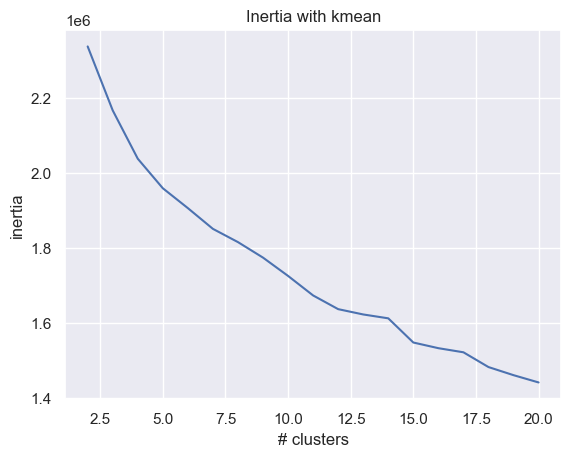

In [12]:
range_n_clusters = np.linspace(min_cluster, max_cluster, max_cluster-min_cluster+1)
ax = sns.lineplot(x=range_n_clusters, y=kmeans_inertia)
ax.set_title('Inertia with kmean')
ax.set_ylabel('inertia')
ax.set_xlabel('# clusters')

kmeans_silhouette = [silhouette_score(np_uncorr, k.labels_)  for k in kmeans_results]


In [13]:
n_clusters = 15
df_occurences, cluster_labels = get_df_occurences(np_uncorr, kmeans_results, n_clusters, min_cluster)
print(df_occurences)

    occurences  percentage
6         3695   19.419772
13        3606   18.952016
11        2746   14.432123
8         2429   12.766069
3         1706    8.966206
7         1332    7.000578
12         802    4.215063
10         688    3.615914
0          628    3.300573
2          600    3.153414
1          516    2.711936
9          173    0.909234
14         103    0.541336
5            2    0.010511
4            1    0.005256


In [14]:
#remove outliers
df_small_cluster = df_occurences[df_occurences['percentage'] < 1]
cluster_to_drop = df_small_cluster.index.values
print(cluster_to_drop)
index_to_keep = [cl not in cluster_to_drop for cl in cluster_labels]

[ 9 14  5  4]


In [23]:
df_no_outliers = df_uncorr.iloc[index_to_keep,:]
df_no_outliers.shape
np_no_outliers = df_no_outliers.to_numpy()
df_no_outliers_not_normalized = df.loc[index_to_keep,df_no_outliers.columns]  # type: ignore

In [16]:
X_embedded_no_outliers = TSNE(n_components=2, learning_rate='auto', init='pca').fit_transform(np_no_outliers)

d:\Perso\Gitcoin\Hackathon_open_data\vGitcoinViz\lib\site-packages\sklearn\manifold\_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


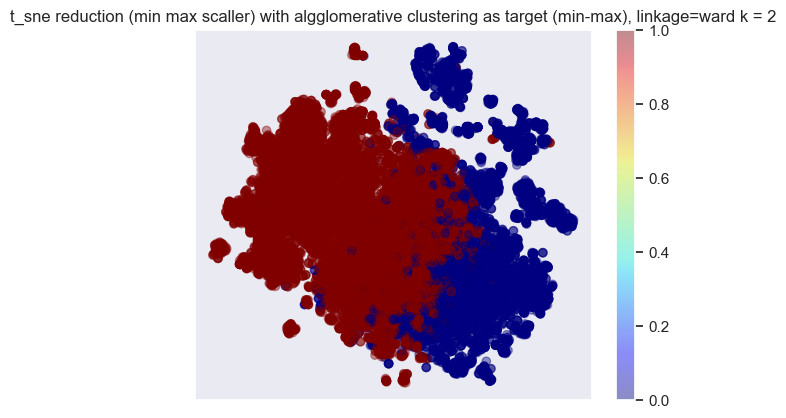

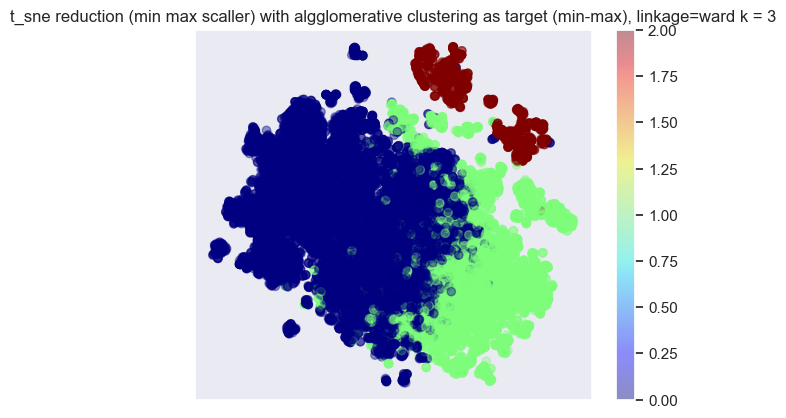

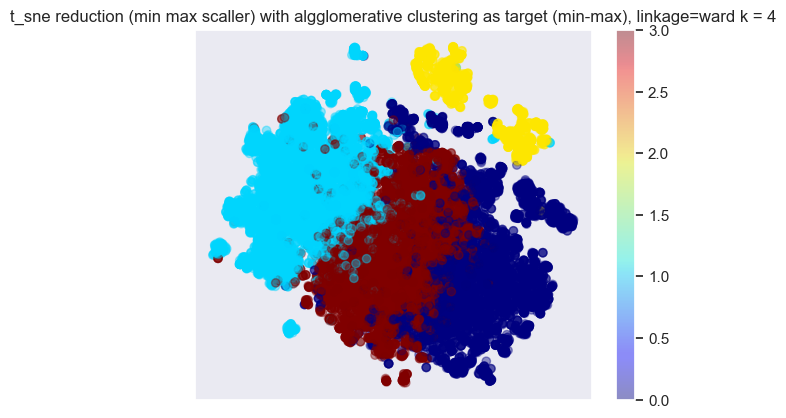

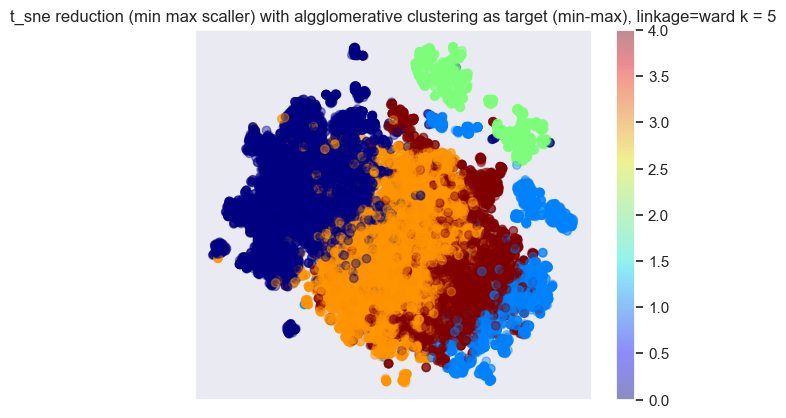

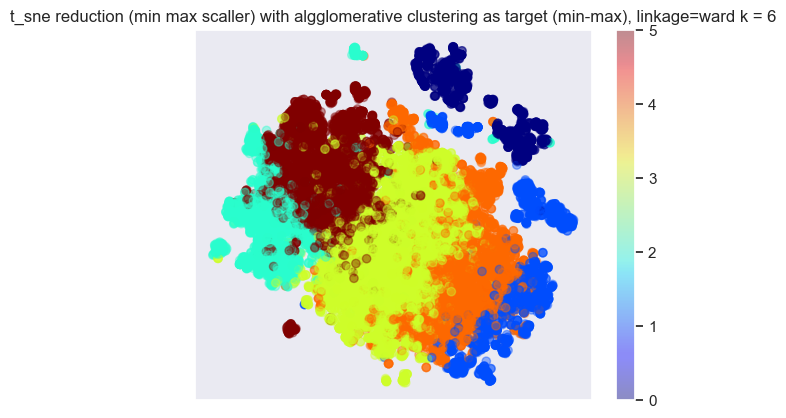

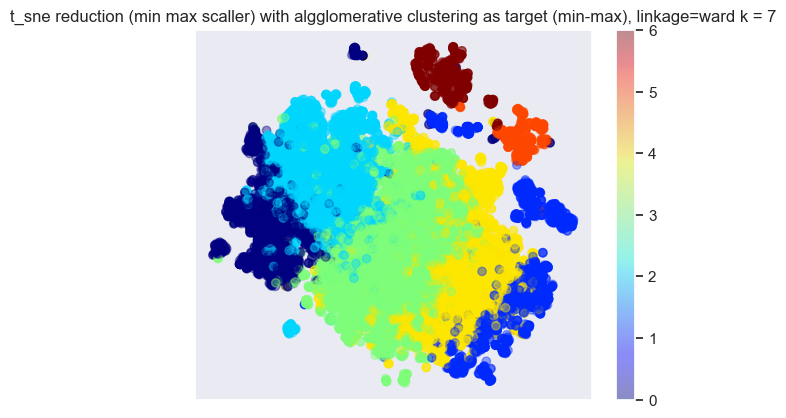

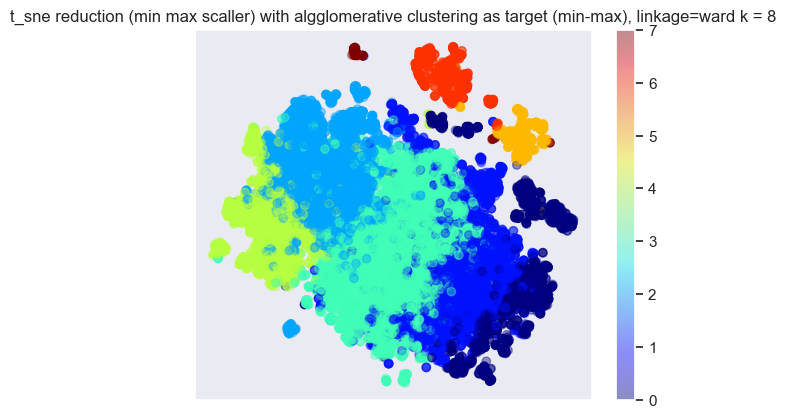

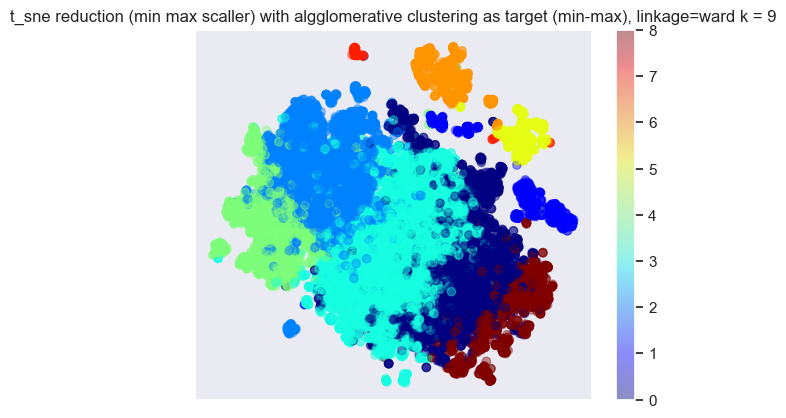

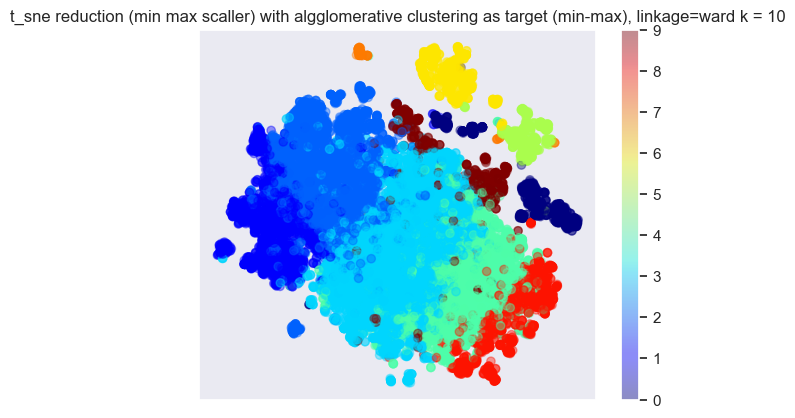

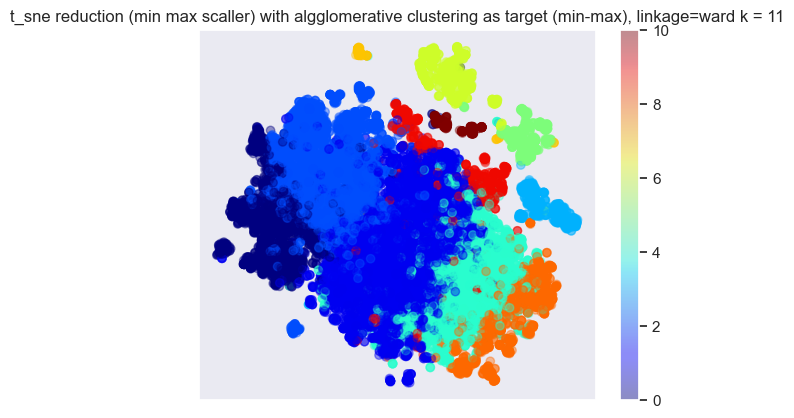

In [17]:
cluster_algo_mima_results = []
for k in range(2,12):
    cluster_agglo_mima = AgglomerativeClustering(n_clusters=k, linkage='ward', compute_distances=True).fit(np_no_outliers)
    cluster_algo_mima_results.append(cluster_agglo_mima)
    scatter_plot_2d(X_embedded_no_outliers, cluster_agglo_mima.labels_, 't_sne reduction (min max scaller) with algglomerative clustering as target (min-max), linkage=ward k = ' + str(k))


In [18]:
from scipy.cluster.hierarchy import dendrogram
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


In [19]:
cluster_agglo_mima.distances_

array([  0.        ,   0.        ,   0.        , ..., 469.97750566,
       512.90975826, 900.80407666])

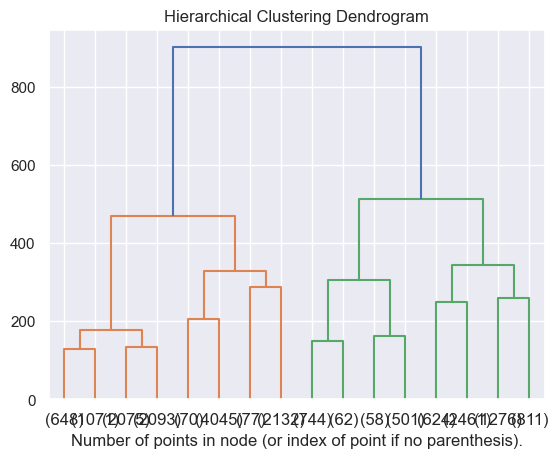

In [20]:
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(cluster_algo_mima_results[1], truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()